## Spot Analysis of BF Correction

Originally written by Alex Broughton

Using Run 12788 for spot, we use images from the seq_num IN (463 503 543 583 623 663 703 743 763). We use calibration products from run 12781 do complete the BF correction in the ISR Task.


In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_29/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0-ext/eups 	setup
lsst_distrib          22.0.0-2-g7baa053+bdcdebdc08 	w_latest current w_2021_29 setup


In [2]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit

In [3]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml"

butler = Butler(repo_path)
registry = butler.registry

In [4]:
def getData(repo, col, fluxkey="base_CircularApertureFlux_70_0_instFlux", shapekey="base_SdssShape_xx"):
    # Pulls out data from run and returns BF table
    
    subbutler = Butler(repo_path,collections=col)
    subregistry = subbutler.registry
    
    datasetRefs = list(subregistry.queryDatasets(
        datasetType="gridSpotSrc",
        collections=col))

    tab = []
    for i, aref in enumerate(datasetRefs):

        # postISRCCD
        raw = subbutler.get("raw",dataId=aref.dataId)
        md = raw.getMetadata()
        exptime = md["EXPTIME"]

        src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
        mdsrc = src.getMetadata()
        x0 = mdsrc['GRID_X0']
        y0 = mdsrc['GRID_Y0']
        
        # Craig's cuts
        minSizeX = 4.0
        maxSizeX = 7.0
        minSizeY = 4.0
        maxSizeY = 7.0
        minFluxRatio = 0.80
        maxFlux = np.nanmax(src['base_SdssShape_instFlux'])
        select = src['base_SdssShape_instFlux'] > maxFlux * minFluxRatio
        spotCatalog  = src.subset(select)
        select = ((src['base_SdssShape_xx'] >= minSizeX) & (src['base_SdssShape_xx'] <= maxSizeX) & 
                (src['base_SdssShape_yy'] >= minSizeY) & (src['base_SdssShape_yy'] <= maxSizeY))

        src  = src.subset(select)
        
        # Center cuts
        maxradius = 10.*np.mean([mdsrc["GRID_XSTEP"], mdsrc["GRID_YSTEP"]])
        distances = np.sqrt((src["spotgrid_x"] - x0)**2 + (src["spotgrid_y"] - y0)**2)
        mask1 = (distances <= maxradius)

        # NaN cuts
        mask0 = (src['spotgrid_index'] >= 0)
        
        src = src[mask0 & mask1]
        
        # Get the peak spot values
        maxADC = np.zeros(len(src))
        s = 15
        if len(src) > 0:
            postisr = subbutler.get("postISRCCD",dataId=aref.dataId)
            image = postisr.getImage().getArray()
            #image = raw.getImage().getArray()
            for i,pt in enumerate(src["spotgrid_index"]):
                x = int(src['spotgrid_y'][i]) # The coordinate systems are flipped
                y = int(src['spotgrid_x'][i])
                xmin = max(0,x-s)
                xmax = min(image.shape[0]-1, x+s)
                ymin = max(0,y-s)
                ymax = min(image.shape[1]-1, y+s)
                maxADC[i] = np.max(image[xmin:xmax,ymin:ymax])
        
        
        if len(src) > 0:
            indxs = np.argsort(src['spotgrid_index'])
            tab.append(
                {
                    "index": i,
                    "dataId": aref.dataId,
                    "exptime": exptime,
                    "numspots" : len(src),
                    "spot_indices": src['spotgrid_index'][indxs],
                    "spotgrid_x": src['spotgrid_x'][indxs],
                    "spotgrid_y": src['spotgrid_y'][indxs],
                    "base_SdssShape_xx": src['base_SdssShape_xx'][indxs],
                    "base_SdssShape_yy": src['base_SdssShape_yy'][indxs],
                    "base_PsfFlux_instFlux": src["base_PsfFlux_instFlux"][indxs],
                    "base_CircularApertureFlux_3_0_instFlux": src["base_CircularApertureFlux_3_0_instFlux"][indxs],
                    "base_CircularApertureFlux_70_0_instFlux": src["base_CircularApertureFlux_70_0_instFlux"][indxs],
                    "maxADC": maxADC[indxs]
                }
            )

    t = Table(tab)
    t_sorted = t[np.argsort(t['exptime'])]

    return t_sorted


#### PTC Curve

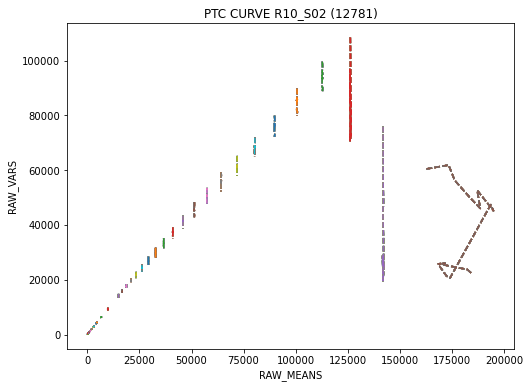

In [5]:
ptcdir = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/abrought/run_12781/bf_work_v5/polynomialfit/ptcs/20210622T200720Z/ptc/"
ptcfile = glob.glob(ptcdir + "*R10_S02*.fits")[0]
hdu = fits.open(ptcfile)
hdu[1].columns

plt.figure(1, figsize=(8,6),facecolor="w")
for amp in hdu[1].data:
    plt.plot(hdu[1].data['RAW_MEANS'], hdu[1].data['RAW_VARS'], "--")
    plt.xlabel("RAW_MEANS")
    plt.ylabel("RAW_VARS")
    plt.title("PTC CURVE R10_S02 (12781)")

#### With BF Correction

Plotted for all spots.
* Note that the 50sec exposure points are almost all masked out because they are all saturated.

/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits(MC_C_20201126_000543): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits(MC_C_20201126_000703): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits(MC_C_20201126_000503): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits(MC_C_20201126_000463): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits(MC_C_20201126_000583): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits(MC_C_20201126_000663): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits(MC_C_20201126_000743): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits(MC_C_20201126_000623): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits(MC_C_20201126_000763): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


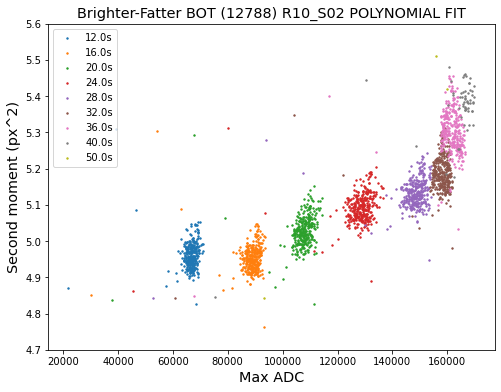

In [6]:
tab_corr = getData(repo=repo_path, col='u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v14/wbfcorr')
plt.figure(2, figsize=(8,6),facecolor="w")           
plt.title("Brighter-Fatter BOT (12788) R10_S02 POLYNOMIAL FIT", fontsize='x-large')

median_flux = []
median_shape = []
for t in tab_corr:
    median_flux.append(np.median(t['maxADC']))
    median_shape.append(np.median(t['base_SdssShape_xx']))
    plt.scatter(t['maxADC'], t['base_SdssShape_xx'], s=2, label=str(t['exptime']) + 's')

plt.legend()
plt.ylim(4.7,5.6)
plt.xlabel("Max ADC", fontsize='x-large')
plt.ylabel("Second moment (px^2)", fontsize='x-large')
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/secondmoment_flux.png")

#### Without BF Correction

/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits(MC_C_20201126_000503): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits(MC_C_20201126_000543): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits(MC_C_20201126_000663): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits(MC_C_20201126_000583): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits(MC_C_20201126_000743): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits(MC_C_20201126_000703): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits(MC_C_20201126_000623): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits(MC_C_20201126_000463): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits(MC_C_20201126_000763): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


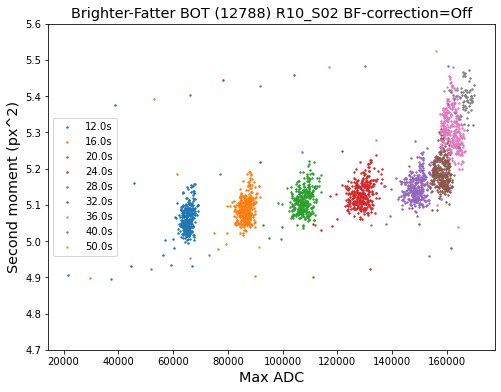

In [7]:
tab_uncorr = getData(repo=repo_path, col='u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v14/wobfcorr')
plt.figure(3, figsize=(8,6),facecolor="w") 
plt.title("Brighter-Fatter BOT (12788) R10_S02 BF-correction=Off", fontsize='x-large')

median_flux = []
median_shape = []
for t in tab_uncorr:
    median_flux.append(np.median(t['maxADC']))
    median_shape.append(np.median(t['base_SdssShape_xx']))
    plt.scatter(t['maxADC'], t['base_SdssShape_xx'], s=2, label=str(t['exptime']) + 's')

plt.legend()
plt.ylim(4.7,5.6)
plt.xlabel("Max ADC", fontsize='x-large')
plt.ylabel("Second moment (px^2)", fontsize='x-large')
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/secondmoment_flux_uncorrected.png")

#### Correction(flux)

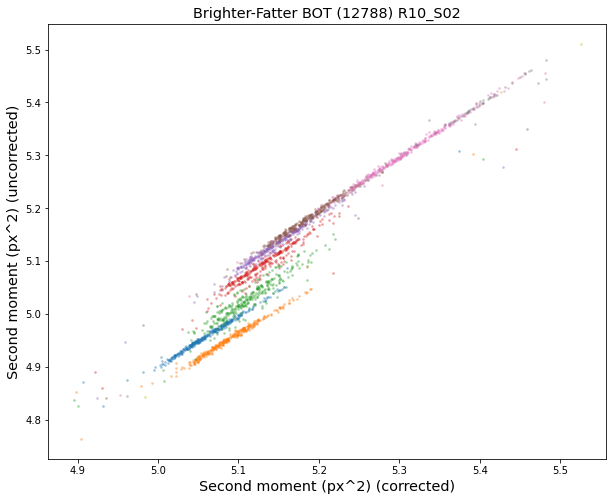

In [8]:
plt.figure(4, figsize=(10,8),facecolor="w")
plt.title("Brighter-Fatter BOT (12788) R10_S02", fontsize='x-large')
 
uncorrected = []
corrected = []
for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    for pt in spots:
        shape_corrected = tc['base_SdssShape_xx'][np.argwhere(tc['spot_indices'] == pt)]
        shape_uncorrected = tuc['base_SdssShape_xx'][np.argwhere(tuc['spot_indices'] == pt)]
        tmp_corrected.append(shape_corrected)
        tmp_uncorrected.append(shape_uncorrected)
    
    corrected.append(tmp_corrected)
    uncorrected.append(tmp_uncorrected)
    
for i,j in zip(uncorrected, corrected):
    plt.scatter(i, j, s=3, alpha=.3)
plt.xlabel("Second moment (px^2) (corrected)", fontsize='x-large')
plt.ylabel("Second moment (px^2) (uncorrected)", fontsize='x-large')
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/secondmoment_secondmoment_corrected_uncorrected.png")




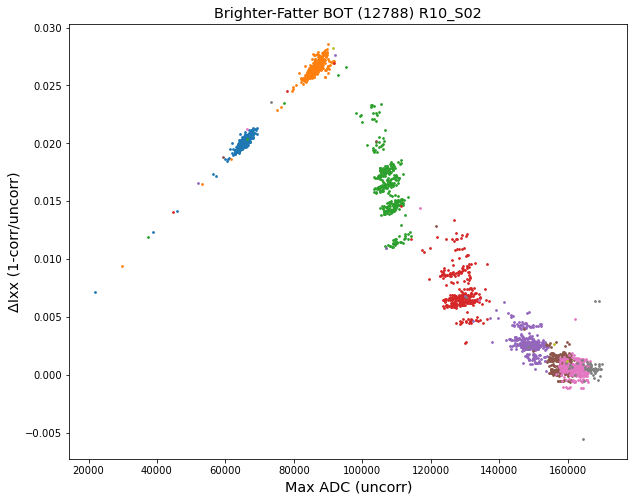

In [9]:
plt.figure(5, figsize=(10,8),facecolor="w")
plt.title("Brighter-Fatter BOT (12788) R10_S02", fontsize='x-large')
 
diffs = []
fluxes = []
for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_diffs = []
    tmp_flux = []
    for pt in spots:
        shape_corrected = tc['base_SdssShape_xx'][np.argwhere(tc['spot_indices'] == pt)]
        shape_uncorrected = tuc['base_SdssShape_xx'][np.argwhere(tuc['spot_indices'] == pt)]

        flux = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
        tmp_diffs.append(1. - shape_corrected/shape_uncorrected)
        tmp_flux.append(flux)
        

    diffs.append(tmp_diffs)
    fluxes.append(tmp_flux)
    
for i,j in zip(fluxes, diffs):
    plt.scatter(i, j, s=3)
plt.xlabel("Max ADC (uncorr)", fontsize='x-large')
plt.ylabel("ΔIxx (1-corr/uncorr)", fontsize='x-large')
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/secondmoment_flux_corrected_uncorrected.png")




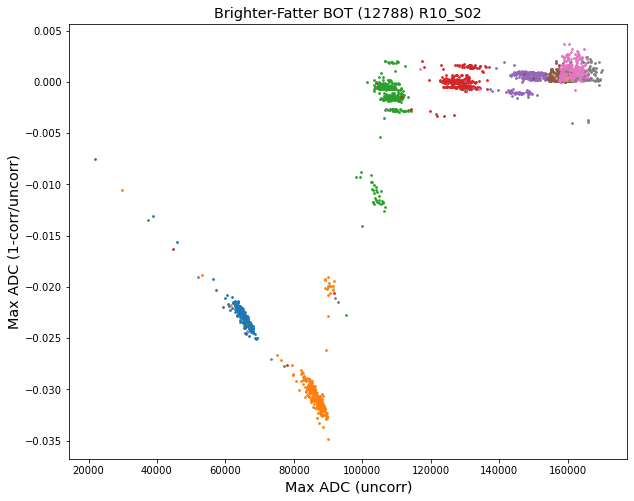

In [10]:
plt.figure(6, figsize=(10,8),facecolor="w")
plt.title("Brighter-Fatter BOT (12788) R10_S02", fontsize='x-large')
 
uncorrected = []
corrected = []
for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    for pt in spots:
        flux_corrected = tc['maxADC'][int(np.argwhere(tc['spot_indices'] == pt))]
        flux_uncorrected = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
        tmp_corrected.append(1. - flux_corrected/flux_uncorrected)
        tmp_uncorrected.append(flux_uncorrected)
    
    corrected.append(tmp_corrected)
    uncorrected.append(tmp_uncorrected)
    
for i,j in zip(uncorrected, corrected):
    plt.scatter(i, j, s=3)
plt.xlabel("Max ADC (uncorr)", fontsize='x-large')
plt.ylabel("Max ADC (1-corr/uncorr)", fontsize='x-large')
#plt.ylim(-0.0025,0.0025)
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/flux_flux_corrected_uncorrected.png")



In [11]:
# Write data to a pickle

byamp_results = []
byamp_corrected_results = []

    
for i, table in enumerate([tab_corr, tab_uncorr]):
    
    for exp in table:
        flux = exp['maxADC']
        shape = exp['base_SdssShape_xx']

        if i==0:
            byamp_corrected_results.append([exp['numspots'],np.nanmedian(flux), np.nanstd(flux), np.nanmedian(shape), np.nanstd(shape)])
        else:
            byamp_results.append([exp['numspots'],np.nanmedian(flux), np.nanstd(flux), np.nanmedian(shape), np.nanstd(shape)])


            
spots_pickle = {'results':byamp_results, 'corrected_results': byamp_corrected_results}
filename = "./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/spots_results_12788_R10_S02.pkl"

if(os.path.isfile(filename)):
    print("Throwing out the old pickle.")
    os.remove(filename)
        
with open(filename, 'wb') as f:
    print("Jarring a new pickle.")
    pkl.dump(spots_pickle, f)
    print("Done.")

Jarring a new pickle.
Done.


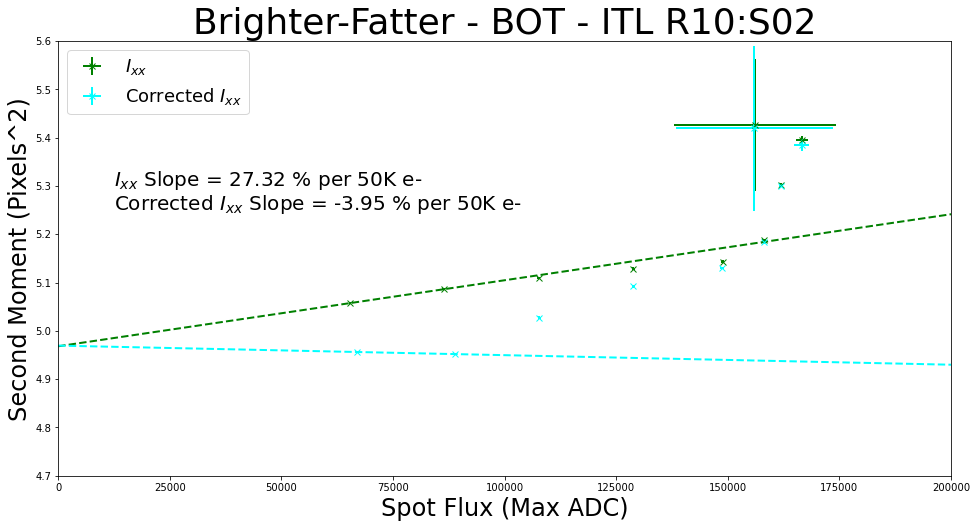

In [12]:
plotCorrection = True
filename = "./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/spots_results_12788_R10_S02.pkl"
with open(filename, 'rb') as f:
    spots_pickle= pkl.load(f)
byamp_results = spots_pickle['results']
if plotCorrection:
    byamp_corrected_results = spots_pickle['corrected_results']

# Now plot the result
plotCorrection=True
syst_fraction = 0
min_slope_index = 0
max_slope_index = len(byamp_results) - 1
max_flux_index = len(byamp_results)
minSpot = 5.0
maxSpot = 5.6
textDelta = (maxSpot - minSpot) / 10
# These next are in case not all fluxes produced good results

# [numspots, np.nanmean(flux), np.nanstd(flux), np.nanmean(x2), np.nanstd(x2), np.nanmean(y2), np.nanstd(y2)]
# [d['numspots'], d['fluxmean'], d['fluxerr'], d['shapemean'], d['shapeerr']]

try:
    results = np.array([byamp_results[i] for i in range(max_flux_index)])
    max_slope_ind = max_slope_index
except:
    results = np.array(byamp_results)
    max_slope_ind = min(len(results) - 4, max_slope_index)
xerror = results[:,2]/np.sqrt(results[:,0])
xyerror = results[:,4] * (syst_fraction + (1 - syst_fraction) / np.sqrt(results[:,0]))


if plotCorrection:
    try:
        corrected_results = np.array([byamp_corrected_results[i] for i in range(max_flux_index)])
        max_slope_ind_corr = max_slope_index
    except:
        corrected_results = np.array(byamp_corrected_results)           
        max_slope_ind_corr = min(len(corrected_results) - 4, max_slope_index)

    corrected_xerror = corrected_results[:,2]/np.sqrt(corrected_results[:,0])
    corrected_xyerror = corrected_results[:,4] * (syst_fraction + (1 - syst_fraction) / np.sqrt(corrected_results[:,0]))

plt.figure(7, figsize=(16,8), facecolor='w')
plt.title("Brighter-Fatter - BOT - ITL R10:S02", fontsize = 36)
# First plot the uncorrected data
plt.errorbar(results[:,1], results[:,3], xerr = xerror, yerr = xyerror, color = 'green', lw = 2, label = '$I_{xx}$', ls='', marker='x')

slope, intercept, r_value, p_value, std_err = stats.linregress(results[0:2,1], results[0:2,3])
xplot=np.linspace(0.0,1.4e7,100)
yplot = slope * xplot + intercept
plt.plot(xplot, yplot, color='green', lw = 2, ls = '--')
tslope = slope * 100.0 * 200000.0
plt.text(12500, 5.3, "$I_{xx}$ Slope = %.2f %% per 50K e-"%tslope, fontsize='20')


if plotCorrection:
    # Now plot the corrected data
    plt.errorbar(corrected_results[:,1], corrected_results[:,3], xerr = corrected_xerror, yerr = corrected_xyerror, color = 'cyan', lw = 2, ls='', marker='x', label = 'Corrected $I_{xx}$')

    slope, intercept, r_value, p_value, std_err = stats.linregress(corrected_results[0:2,1], corrected_results[0:2,3])
    xplot=np.linspace(0.0,1.4e7,100)
    yplot = slope * xplot + intercept
    plt.plot(xplot, yplot, color='cyan', lw = 2, ls = '--')
    tslope = slope * 100.0 * 200000.0
    plt.text(12500, 5.25, "Corrected $I_{xx}$ Slope = %.2f %% per 50K e-"%tslope, fontsize='20')

plt.xlabel('Spot Flux (Max ADC)',fontsize=24)
plt.ylabel('Second Moment (Pixels^2)',fontsize=24)
plt.xlim(0,.2e6)
plt.ylim(4.7, 5.6)
plt.legend(loc= 'upper left',fontsize = 18)
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/spots_results_12788_R10_S02.png")

## Photometry

/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits(MC_C_20201126_000503): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits(MC_C_20201126_000543): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits(MC_C_20201126_000663): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits(MC_C_20201126_000583): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits(MC_C_20201126_000743): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits(MC_C_20201126_000703): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits(MC_C_20201126_000623): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits(MC_C_20201126_000463): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits(MC_C_20201126_000763): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits(MC_C_20201126_000543): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits(MC_C_20201126_000703): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits(MC_C_20201126_000503): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits(MC_C_20201126_000463): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits(MC_C_20201126_000583): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits(MC_C_20201126_000663): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits(MC_C_20201126_000743): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits(MC_C_20201126_000623): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits(MC_C_20201126_000763): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


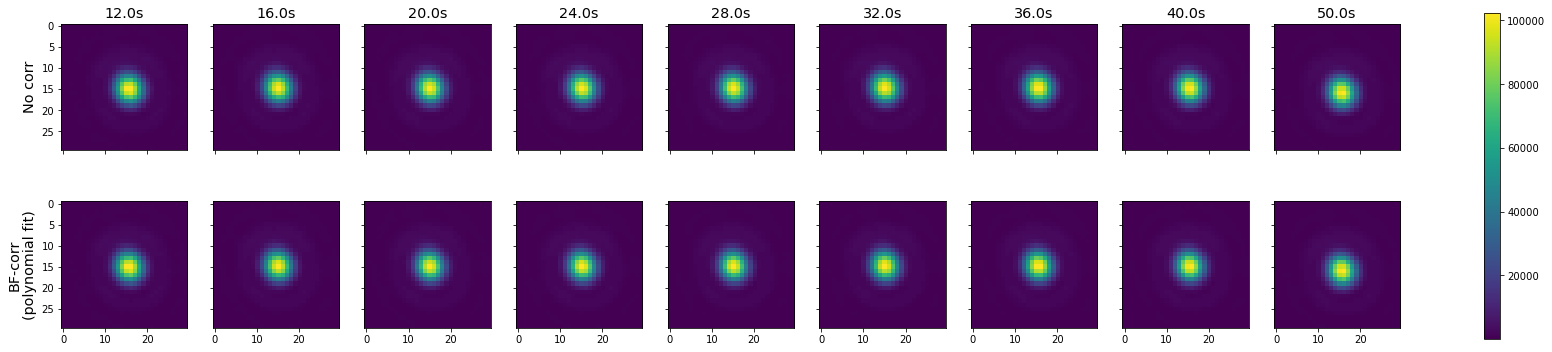

In [13]:
pt=500
s = 15

fig, axs = plt.subplots(2, 9, sharex=True, sharey=True, figsize=(30,6), facecolor='w')


for j, col in enumerate(['u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v14/wobfcorr', 
                         'u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v14/wbfcorr']):
    
    subbutler = Butler(repo_path,collections=col)
    subregistry = subbutler.registry
    
    datasetRefs = list(subregistry.queryDatasets(
        datasetType="gridSpotSrc",
        collections=col))
    
    exptimes = []
    for n, aref in enumerate(datasetRefs):
        exptimes.append(subbutler.get("raw",dataId=aref.dataId).getMetadata()["EXPTIME"])
    datasetRefs = np.asarray(datasetRefs)[np.argsort(exptimes)]
    
    for i, aref in enumerate(datasetRefs):
        # postISRCCD
        postisr = subbutler.get("postISRCCD",dataId=aref.dataId)
        image = postisr.getImage().getArray()
        src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
        try:
            x = int(src['spotgrid_y'][np.argwhere(src['spotgrid_index'] == pt)])
            y = int(src['spotgrid_x'][np.argwhere(src['spotgrid_index'] == pt)])
            xmin = max(0,x-s)
            xmax = min(image.shape[1]-1, x+s)
            ymin = max(0,y-s)
            ymax = min(image.shape[0]-1, y+s)
            im = axs[j][i].imshow(image[xmin:xmax,ymin:ymax])

        except:
            print("Could not find spot.")

            
for ax, r in zip(axs[:,0], ["No corr", "BF-corr\n(polynomial fit)"]):
    ax.set_ylabel(r, fontsize='x-large')

for ax, c in zip(axs[0,:], [str(t)+'s' for t in sorted(exptimes)]):
    ax.set_title(c, fontsize='x-large')
    
fig.colorbar(im, ax=axs.ravel().tolist())
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/single_spot_pt" + str(pt) + ".png")


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits(MC_C_20201126_000543): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits(MC_C_20201126_000703): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000543/MC_C_20201126_000543_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000703/MC_C_20201126_000703_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits(MC_C_20201126_000503): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000503/MC_C_20201126_000503_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits(MC_C_20201126_000463): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000463/MC_C_20201126_000463_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits(MC_C_20201126_000583): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000583/MC_C_20201126_000583_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits(MC_C_20201126_000663): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000663/MC_C_20201126_000663_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits(MC_C_20201126_000743): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000743/MC_C_20201126_000743_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits(MC_C_20201126_000623): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits(MC_C_20201126_000763): Unable to determine the filter


obs.lsst.assembly WARN: /sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000763/MC_C_20201126_000763_R10_S02.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


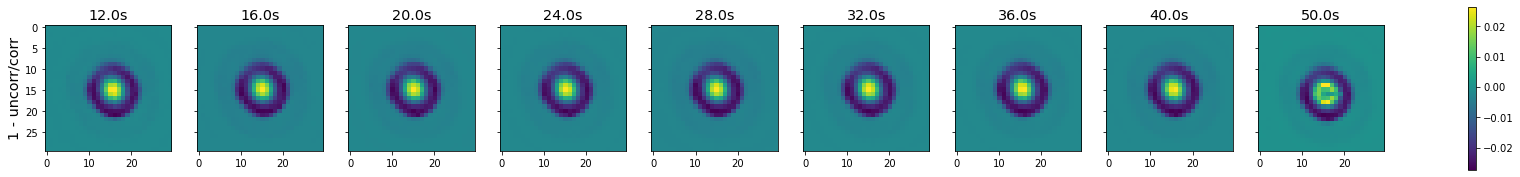

In [14]:
fig, axs = plt.subplots(1, 9, sharex=True, sharey=True, figsize=(30,3), facecolor='w')


#corr
subbutler = Butler(repo_path,collections='u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v14/wbfcorr')
subregistry = subbutler.registry

datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections='u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v14/wbfcorr'))

#uncorr
subbutler2 = Butler(repo_path,collections='u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v14/wobfcorr')
subregistry2 = subbutler2.registry

datasetRefs2 = list(subregistry2.queryDatasets(
    datasetType="gridSpotSrc",
    collections='u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v14/wobfcorr'))

# sort
exptimes = []
for n, aref in enumerate(datasetRefs):
    exptimes.append(subbutler.get("raw",dataId=aref.dataId).getMetadata()["EXPTIME"])
datasetRefs = np.asarray(datasetRefs)[np.argsort(exptimes)]

for i, aref in enumerate(datasetRefs):
    # Get xy
    try:
        src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
        x = int(src['spotgrid_y'][np.argwhere(src['spotgrid_index'] == pt)])
        y = int(src['spotgrid_x'][np.argwhere(src['spotgrid_index'] == pt)])

        image_corr = subbutler.get("postISRCCD",dataId=aref.dataId).getImage().getArray()
        image_uncorr = subbutler2.get("postISRCCD",dataId=aref.dataId).getImage().getArray()
        diff = 1 - image_uncorr/image_corr

        im = axs[i].imshow(diff[x-s:x+s,y-s:y+s])
        
    except:
        continue


axs[0].set_ylabel("1 - uncorr/corr", fontsize='x-large')

for ax, c in zip(axs[:], [str(t)+'s' for t in sorted(exptimes)]):
    ax.set_title(c, fontsize='x-large')
    
fig.colorbar(im, ax=axs.ravel().tolist())
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/single_spot_pt" + str(pt) + ".png")

Yousuke's plot

/tmp/ipykernel_26914/906860963.py:44: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
/tmp/ipykernel_26914/906860963.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212",sharex=ax)


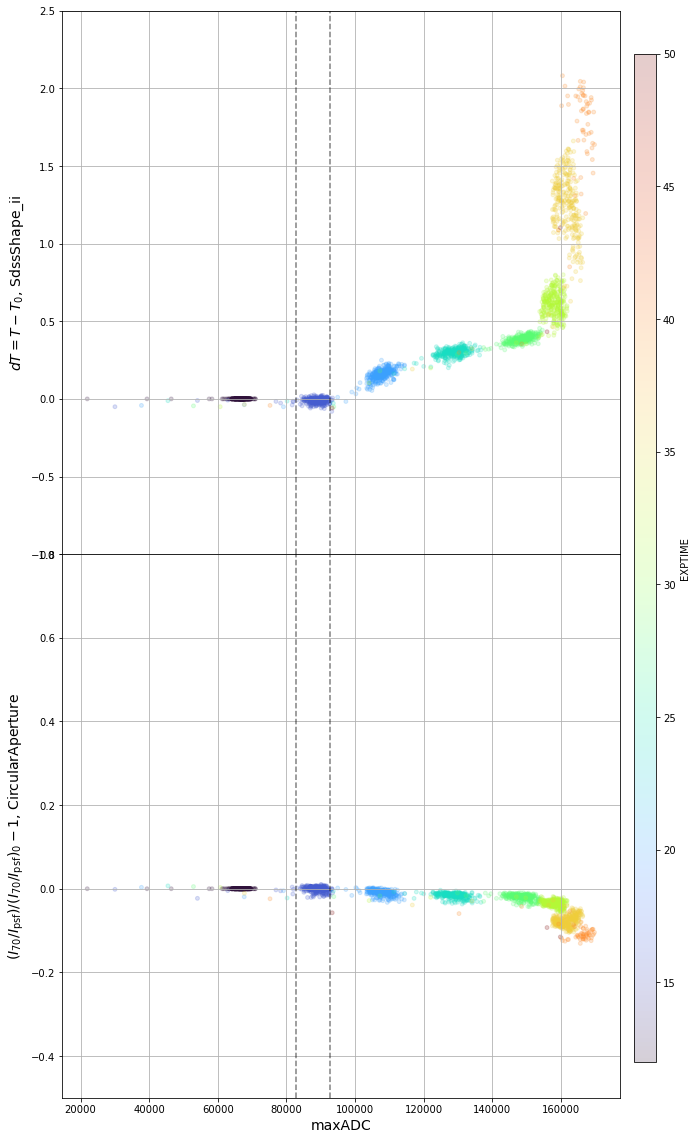

In [19]:
table = tab_corr
ref = table[np.where(table['exptime'] == 12.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-1.,2.5)
ax.grid()

bx = plt.subplot("212",sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=15,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,1e7)
bx.set_ylim(-0.5,0.8)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [82733, 92824] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
    bx.axvline(ch, c="k", ls="--", alpha=0.5)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/summary_Ixx+Iyy_BFcorrected.png")



/tmp/ipykernel_26914/3709108165.py:44: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
/tmp/ipykernel_26914/3709108165.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212",sharex=ax)


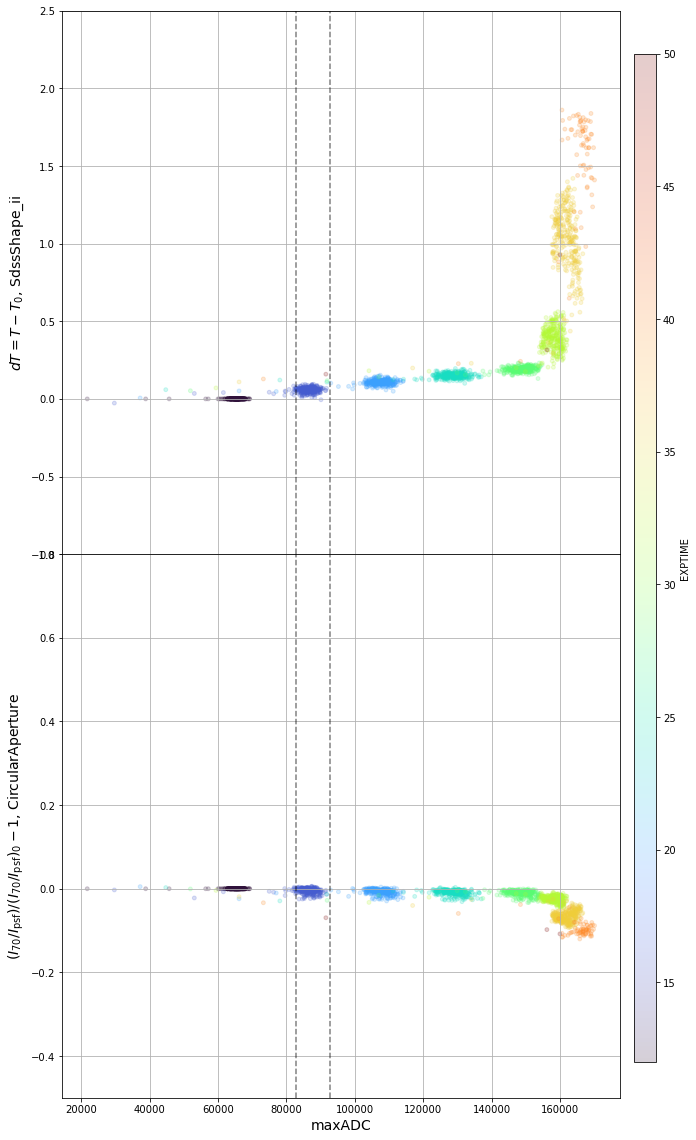

In [16]:
table = tab_uncorr
ref = table[np.where(table['exptime'] == 12.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-1.,2.5)
ax.grid()

bx = plt.subplot("212",sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=15,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,1e7)
bx.set_ylim(-0.5,0.8)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [82733, 92824] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
    bx.axvline(ch, c="k", ls="--", alpha=0.5)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/summary_Ixx+Iyy_NOT-BFcorrected.png")

/tmp/ipykernel_26914/3444617476.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("111",sharex=ax)


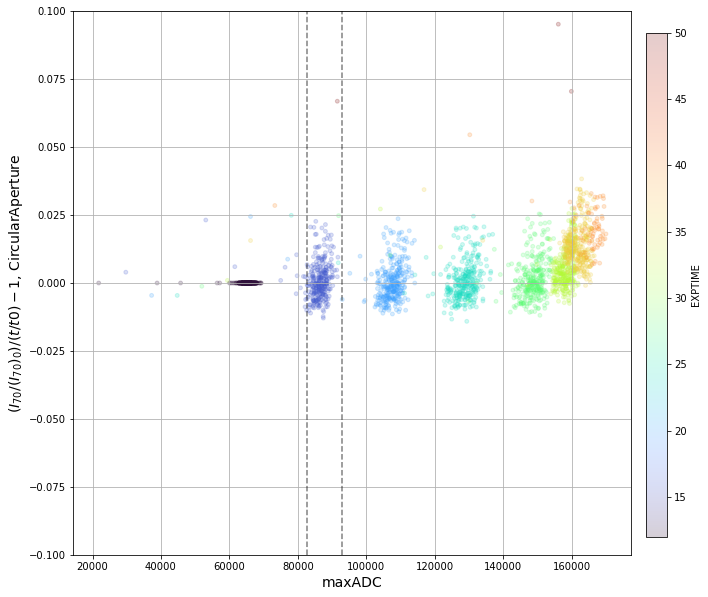

In [17]:
table = tab_uncorr
ref = table[np.where(table['exptime'] == 12.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
zskey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,10), facecolor='w')
#ax = plt.subplot("111")
#sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
#ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
#ax.set_ylim(-1.,2.5)
#ax.grid()
e = np.asarray(e)
bx = plt.subplot("111",sharex=ax)
scb=bx.scatter(x,(zs/(e/12.))-1,c=e,s=15,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/(I_{70})_0) / (t/t0)-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,1e7)
bx.set_ylim(-0.1,0.1)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [82733, 92824] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
    bx.axvline(ch, c="k", ls="--", alpha=0.5)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./plots/itl-R10_S02-25raft-afterlinearity/polynomialfit/centerspots/summary_I70_I70.png")